C:\Users\Sajede Harraz\AppData\Local\Temp\ipykernel_16736\1464685290.py:57: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  cu_qubits = [q[0].index, anc[0].index]
C:\Users\Sajede Harraz\AppData\Local\Temp\ipykernel_16736\1464685290.py:68: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubit_pair1=[q[0].index, q[1].index]
C:\Users\Sajede Harraz\AppData\Local\Temp\ipykernel_16736\1464685290.py:

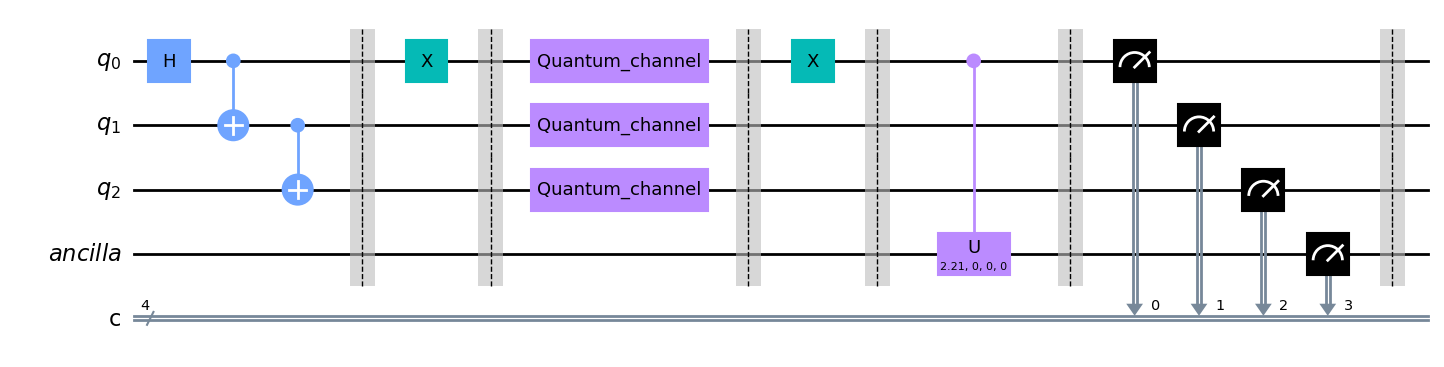

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,transpile, assemble, execute, Aer
from qiskit.quantum_info import Kraus, SuperOp, Operator, partial_trace, DensityMatrix, Statevector,state_fidelity
from qiskit.visualization import plot_bloch_multivector, plot_state_city,  circuit_drawer
from qiskit.circuit import Parameter
from qiskit.providers.aer.noise import amplitude_damping_error,NoiseModel, depolarizing_error, ReadoutError
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
import numpy as np

# Create a quantum circuit
q = QuantumRegister(3, 'q')
anc = QuantumRegister(1, 'ancilla')
c = ClassicalRegister(4, 'c')
qc = QuantumCircuit(q, anc, c)

#Define the damping parameter for the amplitude damping channel
r = 0.3

# Creat 3-qubit GHZ state
qc.h(q[0])
qc.cx(q[0], q[1])
qc.cx(q[1], q[2])
qc.barrier()

#Pre_unilateral rotation to change the structure of the density matrix
qc.x(q[0])
qc.barrier()

# Sending all qubits through amplitude damping channel to communication parties
error =amplitude_damping_error(r, excited_state_population=0, canonical_kraus=True)
qc.append(error, [0])
qc.append(error, [1])
qc.append(error, [2]) 
qc.barrier()

#changing structure of the density matrix
qc.x(q[0])
qc.barrier()

#Employing measurement on only one qubit (Ex: here First qubit)
p=0.8
t=2*np.arctan((np.sqrt(p))/np.sqrt(1-p));
qc.cu(t, 0, 0, 0, q[0], anc[0])
#qc.x(q)# If M1 occured, apply Pauli-X gate on all qubits  
qc.barrier()

####################Considering quantum gates error#######################

#Depolarizing error of CU and CX gate:
cu_error_rate = 0.01 
cx_error_rate = 0.0

#######CU error#####
# Create a depolarizing error for the CU gate
cu_error = depolarizing_error(cu_error_rate, 2) 

cu_qubits = [q[0].index, anc[0].index]

# Create a noise model and add the CU error to it for the specified qubits
noise_model = NoiseModel()
noise_model.add_quantum_error(cu_error, 'cu', cu_qubits)


######Cx error#####
# Create a depolarizing error for the CX gate
cx_error = depolarizing_error(cx_error_rate, 2)

qubit_pair1=[q[0].index, q[1].index]
qubit_pair2=[q[1].index, q[2].index]

# Add the CX error to the noise model for the specified qubits
noise_model.add_quantum_error(cx_error, 'cx', qubit_pair1)
noise_model.add_quantum_error(cx_error, 'cx', qubit_pair2)
###########################################################################

# Measure all qubits
qc.measure([0,1,2,3],[0,1,2,3])
qc.barrier()

# Visualize the circuit
qc.draw('mpl')

In [4]:
qc=qc.reverse_bits ()
Shots_n=100000
method = "statevector"

backend = AerSimulator(method=method)

job = backend.run(qc, method=method, noise_model=noise_model, shots=Shots_n)  # Run the simulation
result = job.result()  # Get the simulation result

counts = result.get_counts()  # Get the measurement counts
print(counts)

{'1111': 19442, '1001': 15677, '1000': 3893, '0000': 34914, '1110': 4958, '1011': 8418, '1101': 8490, '1100': 2096, '1010': 2112}


success: 47973 , fail: 52027 , total: 100000
Bell states counts: {'1000': 3893, '0000': 34914, '1110': 4958, '1100': 2096, '1010': 2112}
Bell new: {'100': 3893, '000': 34914, '111': 4958, '110': 2096, '101': 2112}
probability of sucecess 0.47973
Fidelity= 0.6898231210398692


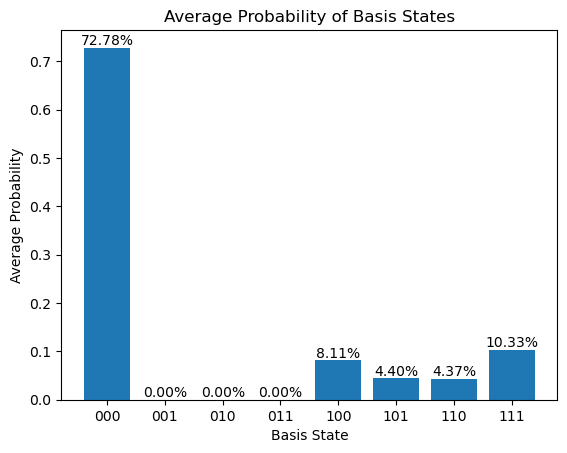

In [5]:
#Follwoing is the code to extract the final denisty matrix, fideelity and success probability of UPS
success, fail = 0, 0
Bell_states = {}
Bell_new= {}
for jj in counts:
        if (jj[-1]=='0'): #To choose the measurement results corresponding to M
            success += counts[jj]
            Bell_state = jj
            if Bell_state in Bell_states:
                Bell_states[Bell_state] += counts[jj]
            else:
                Bell_states[Bell_state] = counts[jj]
        else:
            fail += counts[jj]
            
total = success + fail

# Extract the last character from each Bell state and store it in Bell_new as a dictionary
for i in Bell_states:
    last_char = i[:3]
    if last_char in Bell_new:
        Bell_new[last_char] += Bell_states[i]
    else:
        Bell_new[last_char] = Bell_states[i]

print('success:', success, ',', 'fail:', fail, ',', 'total:', total)
print('Bell states counts:', Bell_states)
print('Bell new:', Bell_new)
print('probability of sucecess',success/total)

# Convert counts to a sorted list of probabilities
basis_states = ['000', '001', '010', '011','100', '101', '110', '111']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states] # Normalized state
#probabilities = [Bell_new.get(state, 0) / Shots_n for state in basis_states] # Un-normalized state

#Finding probabilites for fidelity:
p11 = probabilities[basis_states.index('000')]
p88 = probabilities[basis_states.index('111')]
p18=np.sqrt(p11)*np.sqrt(p88)

#Fidelity of UPS:
Fid=1/2*(p11+p88)+p18
print('Fidelity=',Fid)

# Plot the probabilities as a bar graph
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State')
plt.ylabel('Average Probability')
plt.title(f'Average Probability of Basis States')
for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom')
plt.show()